Script to preprocess for ARIMA Time Series Analysis

In [1]:
# Spark imports
import pyspark
# import pyspark.sql.SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql import Window
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
import pyspark.sql.functions as F
from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql.functions import split, col, lit, isnan, when, count
from pyspark.sql.types import ArrayType, IntegerType, StringType, StructType, StructField

# Python imports
import re

In [2]:
spark = SparkSession.builder.config("SPARK_LOCAL_IP", "192.168.1.2") \
                            .appName("Pre-Preprocess Mission Log 11111-CAR7575-202401")             \
                            .master("spark://192.168.1.2:7077")     \
                            .config("spark.driver.cores", "2")        \
                            .config("spark.driver.memory", "10g")     \
                            .config("spark.executor.memory", "12g")   \
                            .config("spark.executor.cores", "3")      \
                            .config("spark.dynamicAllocation.shuffleTracking.enabled", "true") \
                            .config("spark.dynamicAllocation.enabled", "true") \
                            .config("spark.dynamicAllocation.minExecutors", "5") \
                            .config("spark.dynamicAllocation.maxExecutors", "8") \
                            .config("spark.executor.instances", "5") \
                            .getOrCreate()

24/11/04 09:29:48 WARN Utils: Your hostname, ubuntu-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.1.145 instead (on interface ens33)
24/11/04 09:29:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/04 09:29:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/04 09:29:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
#sc.stop()

In [4]:
#Path to the Parquet file in HDFS
finalized_data_path = "hdfs://192.168.1.2:9000/user/rplenkers-test/correlated_data/11111-CAR7575-202401/final_correlated_dataset_spring-2024/2024-07-08/Full_Dataset_Parquet/2021-12-12 - 2021-12-19/part-00000-729e82b3-3941-4c88-95a5-4c1f6c17151a-c000.snappy.parquet"

In [5]:
#Load the dataset form HDF (Parquet format)
df = spark.read.parquet(finalized_data_path)

In [6]:
#Show the first few rows of the dataset to verify connection
df.show(5)

24/11/04 09:30:09 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+----------+--------------------+-------+-------------+-------------+------------+--------------+----------+----------+------------+----------+-------------+---------+-----+----------+-------------+---------+-------+-------------------+------------------+--------------------+------------+---------------+------------+---------+
|        community_id|conn_state|            duration|history|  src_ip_zeek|src_port_zeek|dest_ip_zeek|dest_port_zeek|local_orig|local_resp|missed_bytes|orig_bytes|orig_ip_bytes|orig_pkts|proto|resp_bytes|resp_ip_bytes|resp_pkts|service|                 ts|               uid|            datetime|label_tactic|label_technique|label_binary|label_cve|
+--------------------+----------+--------------------+-------+-------------+-------------+------------+--------------+----------+----------+------------+----------+-------------+---------+-----+----------+-------------+---------+-------+-------------------+------------------+--------------------+---

In [7]:
def split_csv_text(df):
    # df.show(truncate = 250)
    # splits the "value" column into an array type column.
    split_df = df.withColumn("split_line", F.split("value", ","))
    # split_df.show(truncate = 250)
    # Counts the number of elements in the new "split_line" column.
    split_df = split_df.withColumn("split_count", F.size(col("split_line")))
    # split_df.show(5, truncate = 250)

    # Counts the number of occurrences of each unique count.  
    unique_counts_df = split_df.groupBy(col("split_count")).count().orderBy(col("count"))

    # Gets a list containing each of the unique counts in the dataframe.
    row_counts_list = [row.split_count for row in unique_counts_df.select("split_count").collect()]

    # Creates a dictionary of dataframes filtered on the element count of the split "value" column.  
    row_counts_dfs_dict = {cnt : split_df.select("split_line", "split_count", "source_file", "index").filter(col("split_count") == cnt) for cnt in row_counts_list}

    # Iterates over row_counts_dfs_dict, and creates new columns for each element in the value column.  This creates a new dictionary.  
    # I think you can reassign the new dataframe to row_counts_dfs_dict, but I originally intended to return multipe dataframes.  
    new_cols_dfs_dict = {key: (row_counts_dfs_dict[key].select(row_counts_dfs_dict[key].columns + [row_counts_dfs_dict[key]["split_line"][c].alias("_c"+str(c)) for c in range(row_counts_dfs_dict[key].head()["split_count"])])) for key in row_counts_dfs_dict}

    return new_cols_dfs_dict, unique_counts_df
    

Attribute Selection

In [8]:
#Select relevant columns for time series analysis
df = df.select("ts", "duration", "orig_bytes", "resp_bytes", "orig_ip_bytes", "resp_ip_bytes")

#Handle missing values (example: fill missing values with 0)
df = df.fillna({
    "duration": 0,
    "orig_bytes": 0,
    "resp_bytes": 0,
    "orig_ip_bytes": 0,
    "resp_ip_bytes": 0
})

#Show the data after null handling
df.show(50)

+-------------------+--------------------+----------+----------+-------------+-------------+
|                 ts|            duration|orig_bytes|resp_bytes|orig_ip_bytes|resp_ip_bytes|
+-------------------+--------------------+----------+----------+-------------+-------------+
|1.639887375634962E9|1.382827758789062...|       102|         0|          158|            0|
|1.639813716885203E9|1.001358032226562...|       102|         0|          158|            0|
|1.639812355633012E9|1.096725463867187...|       102|         0|          158|            0|
|1.639853435130795E9|1.001358032226562...|        78|         0|          134|            0|
|  1.6398520133838E9|1.597404479980468...|        78|         0|          134|            0|
|1.639851287384257E9|1.382827758789062...|       102|         0|          158|            0|
|1.639862056381281E9|1.215934753417968...|        78|         0|          134|            0|
|1.639758208133596E9|1.215934753417968...|       102|         0|      

Timestamp and Window Size Selection

In [9]:
#Convert 'ts' to a proper timestamp
df = df.withColumn("ts", F.from_unixtime("ts").cast("timestamp"))

#Define the window size and overlap(start with 15 minutes for testing)
window_size = "15 minutes"
stride = "5 minutes" #creates new window every 5 minutes

#Create the time window with overlapping intervals
#Using rangeBetween to include overlapping windows
df_agg = df.groupBy(F.window("ts", window_size, stride))\
    .agg(
        F.sum("orig_bytes").alias("sum_orig_bytes"),
        F.sum("resp_bytes").alias("sum_resp_bytes"),
        F.sum("orig_ip_bytes").alias("sum_orig_ip_bytes"),
        F.sum("resp_ip_bytes").alias("sum_resp_ip_bytes"),
        F.count("*").alias("connection_count")
    )

#Show the aggregated results
df_agg.printSchema()
df_agg.show(truncate=False)
              

root
 |-- window: struct (nullable = true)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- sum_orig_bytes: long (nullable = true)
 |-- sum_resp_bytes: long (nullable = true)
 |-- sum_orig_ip_bytes: long (nullable = true)
 |-- sum_resp_ip_bytes: long (nullable = true)
 |-- connection_count: long (nullable = false)



+------------------------------------------+--------------+--------------+-----------------+-----------------+----------------+
|window                                    |sum_orig_bytes|sum_resp_bytes|sum_orig_ip_bytes|sum_resp_ip_bytes|connection_count|
+------------------------------------------+--------------+--------------+-----------------+-----------------+----------------+
|{2021-12-18 18:05:00, 2021-12-18 18:20:00}|156           |0             |268              |0                |2               |
|{2021-12-17 16:25:00, 2021-12-17 16:40:00}|156           |48            |268              |160              |1               |
|{2021-12-18 00:40:00, 2021-12-18 00:55:00}|78            |0             |134              |0                |1               |
|{2021-12-18 06:00:00, 2021-12-18 06:15:00}|180           |0             |292              |0                |2               |
|{2021-12-18 03:15:00, 2021-12-18 03:30:00}|156           |0             |268              |0           

In [10]:
#Flatten the window structure
df_agg_flat = df_agg.select(
    F.col("window.start").alias("window_start"),
    F.col("window.end").alias("window_end"),
    "sum_orig_bytes",
    "sum_resp_bytes",
    "sum_orig_ip_bytes",
    "sum_resp_ip_bytes",
    "connection_count"
)

#Sort the DataFrame by window start time
df_agg_sorted = df_agg_flat.orderBy("window_start")

#Show the sorted DataFrame
df_agg_sorted.show(5, truncate=False)

+-------------------+-------------------+--------------+--------------+-----------------+-----------------+----------------+
|window_start       |window_end         |sum_orig_bytes|sum_resp_bytes|sum_orig_ip_bytes|sum_resp_ip_bytes|connection_count|
+-------------------+-------------------+--------------+--------------+-----------------+-----------------+----------------+
|2021-12-17 06:55:00|2021-12-17 07:10:00|102           |0             |158              |0                |1               |
|2021-12-17 07:00:00|2021-12-17 07:15:00|102           |0             |158              |0                |1               |
|2021-12-17 07:05:00|2021-12-17 07:20:00|102           |0             |158              |0                |1               |
|2021-12-17 07:20:00|2021-12-17 07:35:00|204           |0             |316              |0                |2               |
|2021-12-17 07:25:00|2021-12-17 07:40:00|306           |0             |474              |0                |3               |


Visualize Data

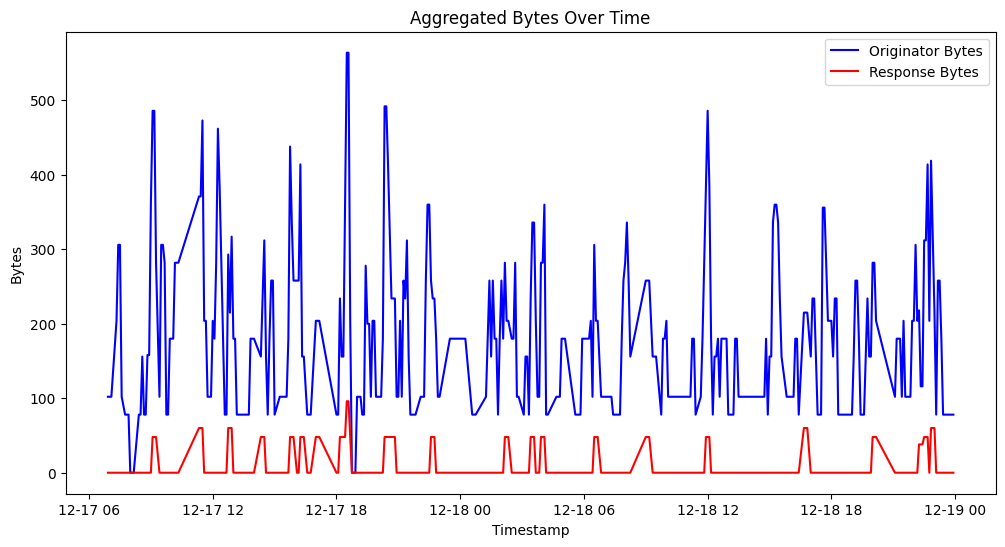

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

#Convert the Spark DataFrame to Pandas for visualization
df_pandas_sorted = df_agg_sorted.toPandas()

#Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_pandas_sorted['window_start'], df_pandas_sorted['sum_orig_bytes'], label = 'Originator Bytes', color = 'blue')
plt.plot(df_pandas_sorted['window_start'], df_pandas_sorted['sum_resp_bytes'], label = 'Response Bytes', color = 'red')

#Titles and Labels
plt.xlabel('Timestamp')
plt.ylabel('Bytes')
plt.title('Aggregated Bytes Over Time')
plt.legend()
plt.show()

Stationarity Test

In [12]:
#Check for Stationarity Using Augmented Dickey-Fuller (ADF) Test
#Consider p-value threshold of 0.05
from statsmodels.tsa.stattools import adfuller

#Perform ADF test on the 'sum_orig_bytes' time series
result = adfuller(df_pandas_sorted['sum_orig_bytes'].dropna())

#Extract and print test statistics
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values: ')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

#Interpret the result
if result[1] < 0.05:
    print("The time series is stationary (reject H0)")
else:
    print("The time series is non-stationary (fail to reject H0)")
          

ADF Statistic: -6.973247
p-value: 0.000000
Critical Values: 
	1%: -3.450
	5%: -2.870
	10%: -2.571
The time series is stationary (reject H0)


Plot of ACF and PACF from Stationary Series

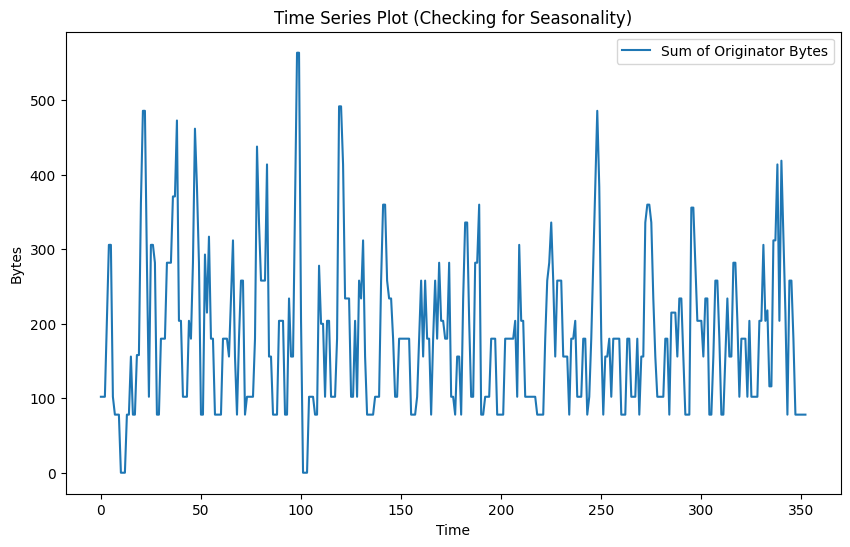

In [13]:
#Check for seasonality
import matplotlib.pyplot as plt

#Plot the original time series
plt.figure(figsize=(10,6))
plt.plot(df_pandas_sorted['sum_orig_bytes'], label='Sum of Originator Bytes')
plt.title('Time Series Plot (Checking for Seasonality)')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.show()

The time series shows evidence of seasonality.


<Figure size 1000x600 with 0 Axes>

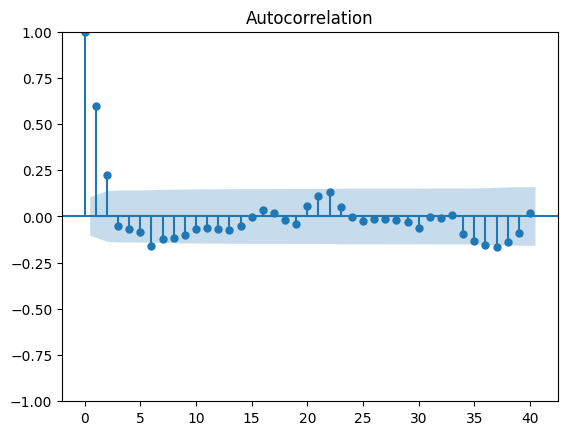

In [14]:
#Seasonality with ACF
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

#Step 1: Calculate ACF Values
acf_values = acf(df_pandas_sorted['sum_orig_bytes'], nlags=50)

#Step 2: Check for significant spikes at regular intervals
#Threshold for significance (Consider 1.96/sqrt(N), where N is the number of observations)
threshold = 1.96 / (len(df_pandas_sorted['sum_orig_bytes']) **0.5)

#Check for significant spikes at regular lags (e.g., lag 12, 24, 36 for monthly seasonality)
seasonal_lags = [12,24, 36] #Adjust based on the expected seasonality period
seasonal = False
for lag in seasonal_lags:
    if abs(acf_values[lag])>threshold:
        seasonal = True
        break

#Step 3: Print a statement indicating if the series is seasonal or not
if seasonal:
    print("The time series shows evidence of seasonality.")
else:
    print("The time series does not show significant evidence of seasonality.")

#Step 4: Plot the ACF for visual purposes
plt.figure(figsize=(10,6))
plot_acf(df_pandas_sorted['sum_orig_bytes'], lags=40)
plt.show()

Determine p and q values using auto_arima() instead of graphical interpretation#

In [15]:
#Install pmdarima if not already installed
#!pip install pmdarima

In [49]:
from pmdarima import auto_arima

#Detected seasonality in auto_arima
#seasonal_period = seasonality # Vlaue detected from the ACF test

#Fit auto_arima to find optimal p,d,q values
auto_model = auto_arima(df_pandas_sorted['sum_orig_bytes'],
                        start_p=0, max_p=50, #Range for p
                        start_q=0, max_q=50, #Range for q
                        d=0,                #Since the series is stationary, d=0
                        seasonal=False,     #Seasonality based on ACF test
                        #m=seasonal_period, #Seasonality manually set to False for testing
                        trace=True,         #Output the process
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

#Print the summary of the best model found
print(auto_model.summary())

#Get the best values of p,q, and d
p, d, q = auto_model.order
print(f"Best p: {p}, d: {d}, q: {q}")


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4777.282, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4178.938, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4493.803, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4180.897, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4180.884, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4182.641, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4118.862, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4274.108, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4105.889, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4100.194, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4096.244, Time=0.11 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=4093.908, Time=0.17 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=4085.554, Time=0.14 sec
 ARIMA(7,0,0)(0,0,0)[0] intercept   : AIC=4081.942, Time=0.12 sec
 ARIMA(8,0,0)(0,0,0)[0] intercept

Fit ARIMA Model

In [52]:
#SARIMAX is used if seasonal data may exist
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Define ARIMA model with selected p, d, q parameters
model = SARIMAX(df_pandas_sorted['sum_orig_bytes'], order=(12,0,0)) #d=0 because data is stationary #(p,d,q)

#Fit the model
model_fit = model.fit()

#Summary of the model
print(model_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79350D+00    |proj g|=  8.19995D-03

At iterate    5    f=  5.79343D+00    |proj g|=  7.91115D-04

At iterate   10    f=  5.79337D+00    |proj g|=  2.06903D-03

At iterate   15    f=  5.79337D+00    |proj g|=  2.26339D-04

At iterate   20    f=  5.79335D+00    |proj g|=  2.53550D-03

At iterate   25    f=  5.79334D+00    |proj g|=  2.01290D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     25     28      1     0     0   

Diagnostic Tests


Ljung-Box Test:
      lb_stat  lb_pvalue
10  10.352405   0.410138

Recommended lb_pvalue is > 0.05

Jarque-Bera Test:
JB Test Stat: 69.597557736767, p-value: 7.71049678630789e-16

Recommended p-value is > 0.05

Durbin-Watson Test:
Durbin-Watson Stat: 1.9940656732567568

Recommended stat close to 2.0 but not greater than 2.0

RMSE:
Root Mean Squared Error: 79.32856444470647


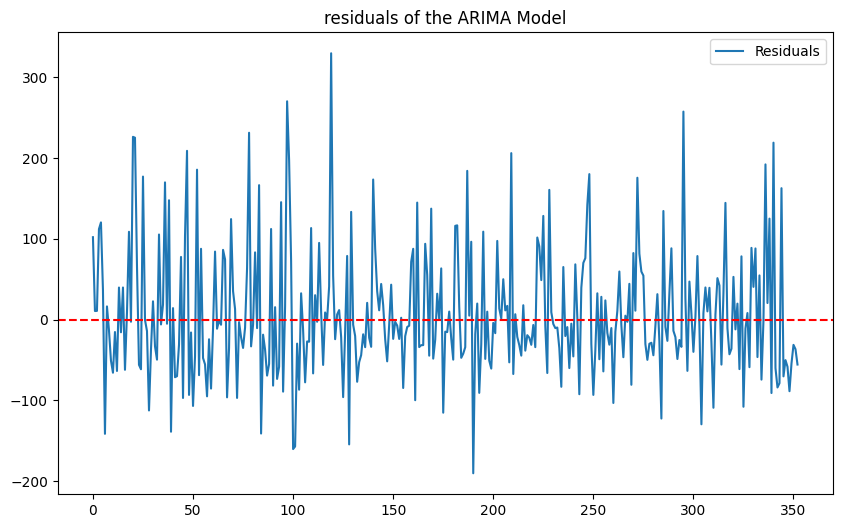

In [54]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
from statsmodels.stats.stattools import durbin_watson

#Extract residuals
residuals = model_fit.resid

#1. Ljung-Box test for autocorrelation in residuals (Begin with 10 Lags)
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box Test:")
print(ljung_box_test)
print("\nRecommended lb_pvalue is > 0.05")

#2. Jarque-Bera test for normality of residuals
jb_test_stat, jb_p_value = jarque_bera(residuals)
print("\nJarque-Bera Test:")
print(f"JB Test Stat: {jb_test_stat}, p-value: {jb_p_value}")
print("\nRecommended p-value is > 0.05")

#3. Durbin-Watson test for autocorrelation in residuals
dw_stat = durbin_watson(residuals)
print("\nDurbin-Watson Test:")
print(f"Durbin-Watson Stat: {dw_stat}")
print("\nRecommended stat close to 2.0 but not greater than 2.0")

#4. Residual Standard Error (RMSE) test for relative performance
rmse = np.sqrt(np.mean(residuals**2))
print("\nRMSE:")
print(f"Root Mean Squared Error: {rmse}")

#5. Residual Plot (Optional for visual inspection)
plt.figure(figsize=(10,6))
plt.plot(residuals, label="Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("residuals of the ARIMA Model")
plt.legend()
plt.show()

In [ ]:
#Apply log transformation to data and refit to ARIMA model to stabalize variance and make residuals closer to normality

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4777.282, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4178.938, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4493.803, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4180.897, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4180.884, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4182.641, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4118.862, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4274.108, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4105.889, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4100.194, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4096.244, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=4093.908, Time=0.06 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=4085.554, Time=0.19 sec
 ARIMA(7,0,0)(0,0,0)[0] intercept   : AIC=4081.942, Time=0.13 sec
 ARIMA(8,0,0)(0,0,0)[0] intercept

/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   20    f=  9.18439D-01    |proj g|=  4.49181D-02

At iterate   25    f=  9.14716D-01    |proj g|=  1.42945D-02

At iterate   30    f=  9.13236D-01    |proj g|=  7.95477D-03

At iterate   35    f=  9.13134D-01    |proj g|=  1.73058D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     37     41      1     0     0   3.788D-06   9.131D-01
  F =  0.91313443777658088     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               SARIMAX Results                                
Dep. Variable:     log_sum_orig_bytes   No. Observations:                  353
Model:           

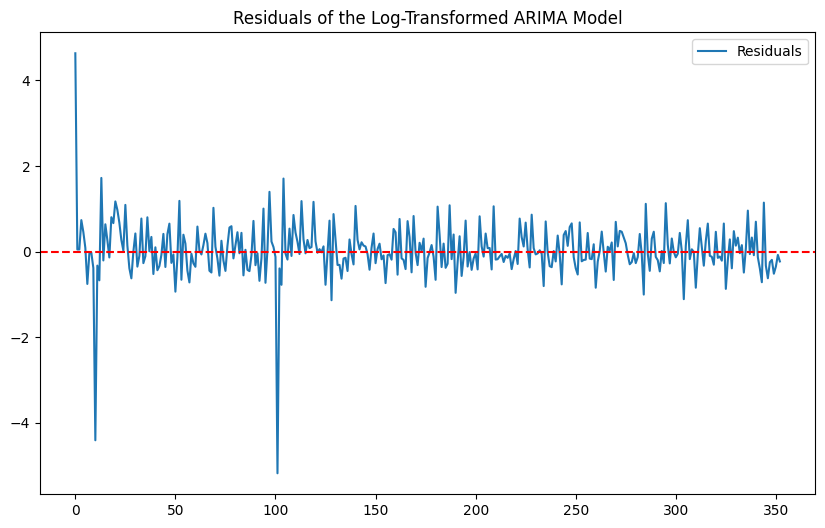

In [56]:
# Step 1: Log-transform the data (ensure no zero values to avoid log(0) issues)
df_pandas_sorted['log_sum_orig_bytes'] = np.log1p(df_pandas_sorted['sum_orig_bytes'])  # log1p handles log(1 + x) to avoid log(0) issues

#Step 2: Fit auto_arima to find optimal p,d,q values
auto_model = auto_arima(df_pandas_sorted['sum_orig_bytes'],
                        start_p=0, max_p=50, #Range for p
                        start_q=0, max_q=50, #Range for q
                        d=0,                #Since the series is stationary, d=0
                        seasonal=False,     #Seasonality based on ACF test
                        #m=seasonal_period, #Seasonality manually set to False for testing
                        trace=True,         #Output the process
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

#Print the summary of the best model found
print(auto_model.summary())

#Get the best values of p,q, and d
p, d, q = auto_model.order
print(f"Best p: {p}, d: {d}, q: {q}")

# Step 3: Fit ARIMA model on log-transformed data
model = SARIMAX(df_pandas_sorted['log_sum_orig_bytes'], order=(p, d, q))

# Step 4: Fit the model
model_fit = model.fit()

# Step 5: Summary of the model
print(model_fit.summary())

# Step 6: Residual diagnostics
residuals = model_fit.resid

# Ljung-Box test
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box Test:")
print(ljung_box_test)

# Jarque-Bera test
jb_test_stat, jb_p_value = jarque_bera(residuals)
print("\nJarque-Bera Test:")
print(f"JB Test Stat: {jb_test_stat}, p-value: {jb_p_value}")

# Durbin-Watson test
dw_stat = durbin_watson(residuals)
print("\nDurbin-Watson Test:")
print(f"Durbin-Watson Stat: {dw_stat}")

# RMSE calculation
rmse = np.sqrt(np.mean(residuals**2))
print("\nRMSE:")
print(f"Root Mean Squared Error: {rmse}")

# Step 6: Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals of the Log-Transformed ARIMA Model")
plt.legend()
plt.show()

Further Investigate Residuals

Outliers detected at the following indices:
0      4.634729
10    -4.408913
101   -5.180486
dtype: float64


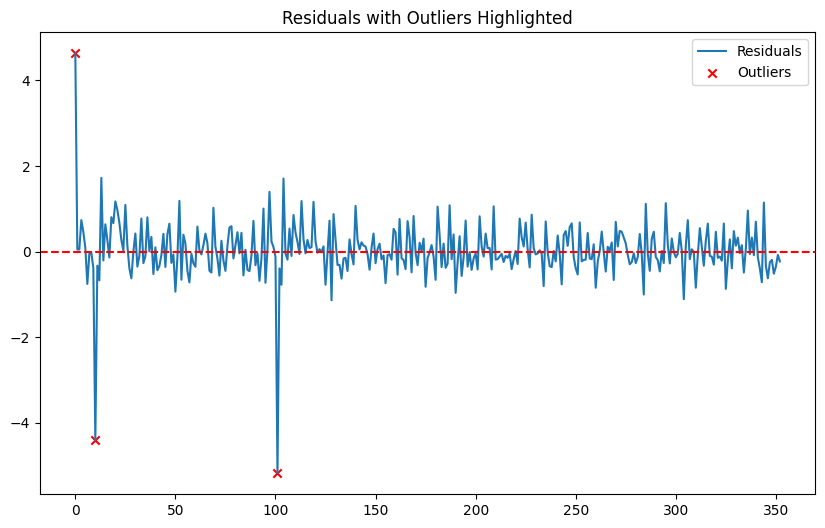

In [57]:
# Step 1: Calculate the residuals from your fitted ARIMA model
residuals = model_fit.resid

# Step 2: Calculate the mean and standard deviation of residuals
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)

# Step 3: Set a threshold for outliers (e.g., 3 standard deviations)
outlier_threshold = 3 * residual_std

# Step 4: Identify the outliers
outliers = residuals[(residuals > residual_mean + outlier_threshold) | (residuals < residual_mean - outlier_threshold)]

# Step 5: Print the identified outliers
print("Outliers detected at the following indices:")
print(outliers)

# Step 6: Plot the residuals with outliers highlighted
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals")
plt.scatter(outliers.index, outliers, color='red', label="Outliers", marker='x')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals with Outliers Highlighted")
plt.legend()
plt.show()

Check for Structural Breaks

No structural break detected (p-value = 0.26462)


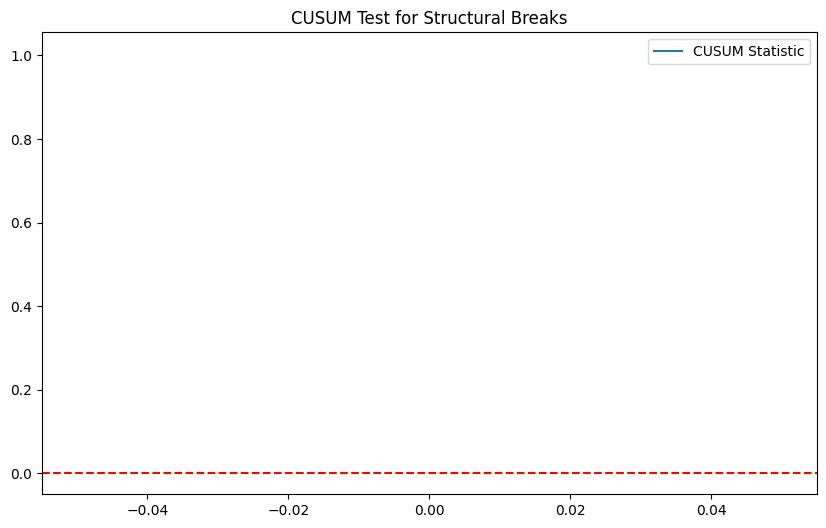

In [58]:
from statsmodels.stats.diagnostic import breaks_cusumolsresid

# Step 1: Perform CUSUM test for structural breaks on residuals
cusum_test = breaks_cusumolsresid(model_fit.resid)

# Step 2: Interpret the result
if cusum_test[1] < 0.05:
    print(f"Structural break detected (p-value = {cusum_test[1]:.5f})")
else:
    print(f"No structural break detected (p-value = {cusum_test[1]:.5f})")

# Step 3: Plot the CUSUM statistic if you want a visual representation
plt.figure(figsize=(10, 6))
plt.plot(cusum_test[0], label="CUSUM Statistic")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("CUSUM Test for Structural Breaks")
plt.legend()
plt.show()

In [21]:
forecast = model_fit.forecast(steps=10)
print(forecast)

353    78.860038
354    70.075368
355    69.010510
356    63.585155
357    64.211523
358    60.854878
359    59.283193
360    56.090050
361    53.927439
362    51.943851
Name: predicted_mean, dtype: float64


#LATER PROCESSING: SPLIT INTO SEPERATE DATAFRAMES ALL DATA AND MALICIOUS DATA ONLY
#ALL DATA: COUNT 
#ALL DATA: BYTES
#MALICIOUS DATA: COUNT
#MALICIOUS DATA: BYTES

In [ ]:
Model Diagnostics